In [2]:
import numpy as np
from scipy import signal, misc
import matplotlib.pyplot as plt
import mne
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost as xgb
import pickle
import os
import pandas as pd
import random
import shutil
from PIL import Image

data_path = r'../data/interim/dataset_1_cheb2/'
output_path = r'../data/processed/deep_learning_data/'

In [3]:
def divide_into_epochs(filename, s_data, output_path):
    start = 0
    end = 2000
    step = int((end-start)/2)
    count = 0
    while end < len(s_data):
        if 'depressed' in filename.lower():
            npy_path = output_path+'train/Depressed/'+filename[:-4]+str(count)+'.jpeg' #remove .csv from filename and append count and .txt extension
            im = Image.fromarray(s_data[start:end].values)
            if im.mode != 'RGB':
                im = im.convert('RGB')
            im.save(npy_path)
            #np.save(npy_path, s_data[start:end].values.astype(np.double))
        elif 'healthy' in filename.lower():
            npy_path = output_path+'train/Healthy/'+filename[:-4]+str(count)+'.jpeg'
            im = Image.fromarray(s_data[start:end].values)
            if im.mode != 'RGB':
                im = im.convert('RGB')
            im.save(npy_path)
            #np.save(npy_path, s_data[start:end].values.astype(np.double))
        count += 1
        start = start+step
        end = end+step

In [4]:
length = []
for filename in os.listdir(data_path):
    s_data = pd.read_csv(os.path.join(data_path, filename), index_col=False).iloc[:,2:-4]
    length.append(len(s_data))
    divide_into_epochs(filename, s_data, output_path)

OSError: cannot write mode F as JPEG

In [30]:
# move 200 data from train folder ot test folder
def move_test_data(N, classname, output_path):
    data_list = os.listdir(output_path+'train/'+classname)
    test_data = random.sample(data_list, k=N)

    for file in test_data:
        shutil.move(output_path+'train/'+classname+'/'+file, output_path+'test/'+classname+'/'+file)

move_test_data(400, 'Depressed', output_path)
move_test_data(400, 'Healthy', output_path)

torch.Size([2000, 31]) 0
Follwing classes are there : 
 ['Depressed', 'Healthy']
Label : Depressed
Length of Train Data : 3243
Length of Validation Data : 2


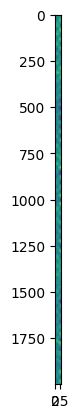

In [33]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

#train and test data directory
data_dir = output_path+"train/"
test_data_dir = output_path+"test/"

def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

#load the train and test data
dataset = DatasetFolder(
    root=data_dir,
    loader=npy_loader,
    extensions=['.npy']
)
test_dataset = DatasetFolder(
    root=test_data_dir,
    loader=npy_loader,
    extensions=['.npy']
)

img, label = dataset[0]

print(img.shape,label)
print("Follwing classes are there : \n",dataset.classes)


def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(0,1))

#display the first image in the dataset
display_img(*dataset[0])

batch_size = 1
val_size = 2
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images = torch.reshape(images, (-1, 1, 2000, 30))
        out = self(images.double())                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = torch.reshape(images, (-1, 1, 2000, 30))
        out = self(images.double())                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [35]:
class EEGClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 2, kernel_size = 15, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(4,4),
            nn.Flatten(),
            nn.Linear(2,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.double()
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
model = EEGClassification()
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)